In [1]:
import numpy as np

import scipy as sp
import scipy.stats as stats
from scipy.stats import linregress,t
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('ytick', labelsize=32) 
plt.rc('xtick', labelsize=32)
plt.rc('text.latex', preamble=r'\usepackage{color}')

import json

import os
import math
from tqdm import tqdm

In [2]:
# Plotting color
Sham = True
ColLS = True
C = np.array([[166,206,227],
[31,120,180],
[178,223,138],
[51,160,44],
[251,154,153],
[227,26,28],
[253,191,111],
[255,127,0],
[202,178,214],
[106,61,154],
[255,255,153],
            [169,169,169],
             [128,128,128]])
C = C/255.
ColorDict = {'mean':0,'median':1,'Control': 1,'CamKII':3,'Calcineurin':7,'CHX':5,'Anisomycin':9,'Sham':-1,'CamKII_alt':3,'CHX_alt':5,}

labelDict = {'CamKII':'AIP','Calcineurin':'FK506','Control':'Control','Sham':'Sham','CHX':'CHX','Anisomycin':'Anisomycin'}

spineplot = np.arange(1,16,0.5)
lw    = 4
fs    = 20

Fulltimes = [-15,-10,-5,2,10,20,30,40]

tmin    =  0
tmax    =  40
tpts    =  tmax*1000+1
dt     = (tmax-tmin)/tpts
tvec  = np.linspace(tmin,tmax,tpts)

DatDir = './DataProcessed/'

In [3]:
def PreSortData(RealDat,Flag):
    
    Pot = []
    for i,d in enumerate(RealDat):
        if(abs((d[3]-d[:3].mean())/d[:3].std())>1.96 and d[3]-d[:3].mean()>0):
            Pot.append(Flag)
        else:
            Pot.append(not Flag)
    return np.delete(RealDat,Pot,axis=0)

def PreSortData2(RealDat,Flag):
    
    Pot = []
    for i,d in enumerate(RealDat):
        if(abs((d[3]-d[:3].mean())/d[:3].std())>1.96 and d[3]-d[:3].mean()>0):
            Pot.append(Flag)
        else:
            Pot.append(not Flag)
    return np.delete(RealDat,Pot,axis=0),Pot

def LoadOneSpine(Dir,Filter=True):

    Syn_a_arr = []
    for d in tqdm(os.listdir(Dir)):
        print(d)
        try:
            with open(Dir+d+'/Spine/Synapse_l.json', 'r') as fp: Syn_a_arr.append(json.load(fp))
        except Exception as e:
            print(e)
            
    dists = []
    means = []
    lmeans = []
    for Syns in Syn_a_arr:
        d = []
        m = []
        lm = []
        for S in Syns:
            d.append(S["distance"])
            m.append(S["mean"])
            lm.append(S["local_bg"])
        dists.append(d)
        means.append(m)
        lmeans.append(lm)
    dists = np.array(dists)
    means = np.array(means)
    lmeans = np.array(lmeans)
    means = np.squeeze(means)
    lmeans = np.squeeze(lmeans)
    means = means-lmeans
    
    if(Filter):
        meansS = PreSortData(means,False)
    else:
        meansS = means
    meansS = (meansS.T/(meansS[:,:3].mean(axis=-1)))
    
    return meansS

def LoadSevenSpine(Dir,Flag=True):
    Syn_a_arr = []
    for d in tqdm(os.listdir(Dir)):
        print(d)
        try:
            with open(Dir+d+'/Spine/Synapse_l.json', 'r') as fp: Syn_a_arr.append(json.load(fp))
        except Exception as e:
            print(e)
            
    dists = []
    means = []
    lmeans = []
    for Syns in Syn_a_arr:
        d = []
        m = []
        lm = []
        for S in Syns:
            d.append(S["distance"])
            m.append(S["mean"])
            lm.append(S["local_bg"])
        dists.append(d)
        means.append(np.array(m)-np.array(lm))

    middle = [np.array(m)[np.argsort(d)[3]] for m,d in zip(means,dists)]
    middleS = np.vstack(middle).squeeze()
    
    extreme = [np.array(m)[np.argsort(d)[[0,-1]]] for m,d in zip(means,dists)]
    extremeS = np.vstack(extreme).squeeze()
    if(Flag):
        middleS = PreSortData(middleS,False)
        extremeS = PreSortData(extremeS,False)
    middleS = (middleS.T/(middleS[:,:3].mean(axis=-1)))
    extremeS = (extremeS.T/(extremeS[:,:3].mean(axis=-1)))

    return [middleS,extremeS],[np.array(d)-min(d) for d in dists]

def LoadSevenSpine2(Dir,Flag=True):
    Syn_a_arr = []
    for d in tqdm(os.listdir(Dir)):
        print(d)
        try:
            with open(Dir+d+'/Spine/Synapse_l.json', 'r') as fp: Syn_a_arr.append(json.load(fp))
        except Exception as e:
            print(e)
            
    dists = []
    means = []
    lmeans = []
    for Syns in Syn_a_arr:
        d = []
        m = []
        lm = []
        for S in Syns:
            d.append(S["distance"])
            m.append(S["mean"])
            lm.append(S["local_bg"])
        dists.append(d)
        means.append(np.array(m)-np.array(lm))

    middle = [np.array(m)[np.argsort(d)[[2,3,4]]] for m,d in zip(means,dists)]
    middleS = np.vstack(middle).squeeze()
    
    extreme = [np.array(m)[np.argsort(d)[[0,1,-2,-1]]] for m,d in zip(means,dists)]
    extremeS = np.vstack(extreme).squeeze()
    if(Flag):
        middleS = PreSortData(middleS,False)
        extremeS = PreSortData(extremeS,False)
    middleS = (middleS.T/(middleS[:,:3].mean(axis=-1)))
    extremeS = (extremeS.T/(extremeS[:,:3].mean(axis=-1)))

    return [middleS,extremeS],[np.array(d)-min(d) for d in dists]

def LoadSevenSpine3(Dir,Flag=True):
    Syn_a_arr = []
    for d in tqdm(os.listdir(Dir)):
        print(d)
        try:
            with open(Dir+d+'/Spine/Synapse_l.json', 'r') as fp: Syn_a_arr.append(json.load(fp))
        except Exception as e:
            print(e)
            
    dists = []
    means = []
    lmeans = []
    for Syns in Syn_a_arr:
        d = []
        m = []
        lm = []
        for S in Syns:
            d.append(S["distance"])
            m.append(S["mean"])
            lm.append(S["local_bg"])
        dists.append(d)
        means.append(np.array(m)-np.array(lm))
    means = np.vstack(means).squeeze()
    meansS = (means.T/(means[:,:3].mean(axis=-1))).T
    if(Flag):
        meansS,p = PreSortData2(meansS,False)
    
    return np.array(meansS),[np.array(d) for d in dists],p


def LoadThreeSpine(Dir,Flag):
    Syn_a_arr = []
    for d in tqdm(os.listdir(Dir)):
        try:
            with open(Dir+d+'/Spine/Synapse_l.json', 'r') as fp: Syn_a_arr.append(json.load(fp))
        except Exception as e:
            print(e)

    dists = []
    means = []
    lmeans = []
    for Syns in Syn_a_arr:
        d = []
        m = []
        lm = []
        for S in Syns:
            d.append(S["distance"])
            m.append(S["mean"])
            lm.append(S["local_bg"])
        dists.append(d)
        means.append(m)
        lmeans.append(lm)
    dists = np.array(dists)
    means = np.array(means)
    lmeans = np.array(lmeans)

    means = np.squeeze(means)
    lmeans = np.squeeze(lmeans)
    means = means-lmeans
    
    middle = [means[i,np.argsort(dists,axis=1)[i,1]] for i in range(7)]
    lower = [means[i,np.argsort(dists,axis=1)[i,0]] for i in range(7)]
    upper = [means[i,np.argsort(dists,axis=1)[i,2]] for i in range(7)]
    middleS = np.array(middle)
    extremeS = np.vstack([lower,upper])
    if(Flag):
        middleS = PreSortData(middleS,False)
        extremeS = PreSortData(extremeS,False)
    middleS = (middleS.T/(middleS[:,:3].mean(axis=-1)))

    extremeS = (extremeS.T/(extremeS[:,:3].mean(axis=-1)))

    return [middleS,extremeS],(dists.T-dists.min(axis=-1)).T

def Load15Spine(Dir,Flag=True):
    Syn_a_arr = []
    for d in tqdm(os.listdir(Dir)):
        print(d)
        try:
            with open(Dir+d+'/Spine/Synapse_l.json', 'r') as fp: Syn_a_arr.append(json.load(fp))
        except Exception as e:
            print(e)
            
    dists = []
    means = []
    lmeans = []
    for Syns in Syn_a_arr:
        d = []
        m = []
        lm = []
        for S in Syns:
            d.append(S["distance"])
            m.append(S["mean"])
            lm.append(S["local_bg"])
        dists.append(d)
        means.append(np.array(m)-np.array(lm))

    middle = [np.array(m)[np.argsort(d)[[6,7,8]]] for m,d in zip(means,dists)]
    middleS = np.vstack(middle).squeeze()

    extreme = [np.array(m)[np.argsort(d)[[0,1,2,-3,-2,-1]]] for m,d in zip(means,dists)]
    extremeS = np.vstack(extreme).squeeze()
    
    if(Flag):
        middleS = PreSortData(middleS,False)
        extremeS = PreSortData(extremeS,False)
    
    middleS = (middleS.T/(middleS[:,:3].mean(axis=-1)))
    extremeS = (extremeS.T/(extremeS[:,:3].mean(axis=-1)))

    return [middleS,extremeS],[np.array(d)-min(d) for d in dists]

def func(x, a, b):
    return (a/(x))+b

In [4]:
class SpatialModel():
    def __init__(self,CParams,P0Params,gamma,zetaS,FParams,C0Params,tMax,xMax,stims):

        self.a1 = CParams[0]
        self.a2 = CParams[1]

        self.b1 = P0Params[0]
        self.b2 = P0Params[1]
        self.rho = P0Params[2]

        self.gamma = gamma

        self.zeta1 = zetaS[0]
        self.zeta2 = zetaS[1]
        self.nu   = FParams[0]
        self.phi  = FParams[1]

        self.lam = C0Params[0]
        self.mu  = C0Params[1]
        self.C_s = C0Params[2]
        self.C_d = C0Params[3]


        self.dx = 0.01
        self.x = np.arange(-xMax,xMax,self.dx)


        self.dt = 0.0025#min(0.001,self.dx*self.dx/(4*max(self.a1,self.b1)))
        self.tMax = tMax
        self.tvec = np.arange(0,tMax+self.dt,self.dt)

        Cd = self.initC(stims)
        Pd = 1-Cd
        self.C  = np.zeros_like(self.x) 
        PMod  = np.zeros_like(self.x) 
        
        self.P  = np.zeros_like(self.x)
        self.P0 = np.ones_like(self.x)
        
        self.S  = np.ones_like(self.x)

        for xs,c in zip(stims[0],Cd):
            self.C += (self.C_s+c)*np.exp(-SpineWidth*(self.x-xs)**2)
        for xs,c in zip(stims[0],Pd):
            PMod += (c)*np.exp(-SpineWidth*(self.x-xs)**2)
        
        self.P0 = self.rho*(self.P0-PMod)

        self.C_tot  = []
        self.P_tot  = []
        self.S_tot  = []
        self.P0_tot = []

    def CRHS(self):
    
        return self.a1*self.diff2(self.C)-self.a2*self.C

    def P0RHS(self):
        
        return self.b1*self.diff2(self.P0)-self.b2*self.C*self.P0

    def PRHS(self):
        
        return  self.b1*self.diff2(self.P) + self.b2*self.C*self.P0 - self.gamma*self.P

    def SRHS(self):
        return  self.zeta1*self.C + self.P*self.zeta2*self.F(self.S)

    def F(self,K):
        return -np.tanh(self.phi*(K-self.nu))
        
    def diff2(self,y):
        
        d2C = np.zeros_like(y)
        
        d2C[1:-1] = (np.roll(y,1)[1:-1]+np.roll(y,-1)[1:-1]-2*y[1:-1])/(self.dx*self.dx)
        
        return d2C

    def initC(self,stims,lam=1):
        x_stims = stims[0]
        t_stims = stims[1]
        C_shared     = np.ones_like(x_stims).astype(np.float64)
        n_stims = len(x_stims)
        if(n_stims>1):
            for i in range(n_stims):            
                mod = 0
                for j in range(n_stims):
                    if(i==j):
                        pass
                    else:
                        mod += (abs(x_stims[i]-x_stims[j])/(1+abs(x_stims[i]-x_stims[j])))**lam
                C_shared[i] = C_shared[i]*((mod+1)/(n_stims))
        return C_shared*self.C_d
    
    def Simulate(self):

        for _ in np.arange(0,self.tMax+self.dt,self.dt):
            RC   = self.CRHS()
            RP0  = self.P0RHS()
            RP   = self.PRHS()
            RS   = self.SRHS()

            self.C  = self.C  + self.dt*RC
            self.P0 = self.P0 + self.dt*RP0
            self.P  = self.P  + self.dt*RP
            self.S  = self.S  + self.dt*RS

            self.C_tot.append(self.C)
            self.P0_tot.append(self.P0)
            self.P_tot.append(self.P)
            self.S_tot.append(self.S)

        self.C_tot  = np.array(self.C_tot)
        self.P0_tot = np.array(self.P0_tot)
        self.P_tot  = np.array(self.P_tot)
        self.S_tot  = np.array(self.S_tot)


In [5]:
def initC(stims,C_d,lam=1):
    x_stims = stims[0]
    t_stims = stims[1]
    C_shared     = np.ones_like(x_stims).astype(np.float64)
    n_stims = len(x_stims)
    if(n_stims>1):
        for i in range(n_stims):            
            mod = 0
            for j in range(n_stims):
                if(i==j):
                    pass
                else:
                    mod += (abs(x_stims[i]-x_stims[j])/(1+abs(x_stims[i]-x_stims[j])))
            C_shared[i] = C_shared[i]*((mod+1)/(n_stims))
    return C_shared*C_d

def RunSimul2(cPar,p0Par,pPar,zeta,phi,nu,stims):
    dx = 0.01
    x = np.arange(-2,2,dx)
    rho = 0.5

    C1  = np.zeros_like(x) 
    C  = np.zeros_like(x) 
    PMod  = np.zeros_like(x) 

    Cd = initC(stims,2)
    Pd = 1-Cd
    for xs,c in zip(stims[0],Cd):
        C1 += (Cs)*np.exp(-1000*(x-xs)**2)
        C += (Cs+c)*np.exp(-1000*(x-xs)**2)
        
            

    P0 = np.ones_like(x)

    for xs,c in zip(stims[0],Pd):
        PMod += (c)*np.exp(-1000*(x-xs)**2)

    P0 = rho*(P0-PMod)

    dt = dx*dx/(4*max(pPar[0],cPar[0]))
    Tmax = 40
    tvec = np.arange(0,Tmax+dt,dt)

    P = np.zeros_like(x)
    S = np.ones_like(x)

    C_tot  = []
    P0_tot = []
    P_tot  = []
    S_tot  = []
    for t in tqdm(np.arange(0,Tmax+dt,dt)):
        RC = CRHS(C,dx,cPar)
        RP0 = P0RHS(P0,C,dx,p0Par)
        RP   = PRHS(P,P0,C,dx,pPar)
        RS  = SRHS(C,direc(S,nu,phi)*P,zeta)
        C  = C  + dt*RC
        P0 = P0 + dt*RP0
        P  = P  + dt*RP
        S  = S  + dt*RS
        C_tot.append(C)
        P0_tot.append(P0)
        P_tot.append(P)
        S_tot.append(S)
    C_tot  = np.array(C_tot)
    P0_tot = np.array(P0_tot)
    P_tot  = np.array(P_tot)
    S_tot  = np.array(S_tot)

    return S_tot

def CRHS(C,dx,CParams):
    
    a1 = CParams[0]
    a2 = CParams[1]
    
    return a1*diff2(C,dx)-a2*C

def P0RHS(P0,C,dx,P0Params):
    b1 = P0Params[0]
    b2 = P0Params[1]
    
    return b1*diff2(P0,dx)-b2*C*P0

def PRHS(P,P0,C,dx,PParams):
    
    c1 = PParams[0]
    c2 = PParams[1]
    c3 = PParams[2]
    
    return  c1*diff2(P,dx) - c2*P + c3*C*P0

def SRHS(C,P,zeta):
    return 2*C + P*zeta

def direc(P,nu,phi):
    return -np.tanh(phi*(P-nu))
    
def diff2(y,dx):
    
    d2C = np.zeros_like(y)
    
    d2C[1:-1] = (np.roll(y,1)[1:-1]+np.roll(y,-1)[1:-1]-2*y[1:-1])/(dx*dx)
    
    return d2C



# Figure 1

## f

(0.0, 2.0)

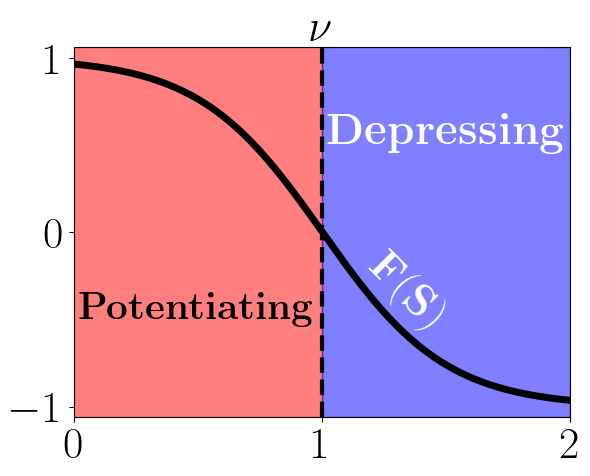

In [6]:
x = np.arange(0,2,0.01)
plt.plot(x,-np.tanh(2*(x-1)),lw = 5,c='k')
plt.axvline(1,lw=3,ls='--',c='k')
plt.text(0.95,1.1,r'\bf{$\nu$}',fontsize=32)
plt.axvspan(0, 1, alpha=0.5, color='red')
plt.axvspan(1, 2, alpha=0.5, color='blue')
plt.text(0.02,-0.5,r'\bf Potentiating',fontsize=28)
plt.text(1.02,0.5,r'\bf Depressing',fontsize=32,c='w')
plt.text(1.15,-0.55,r'$\mathbf{F(S)}$',fontsize=32,rotation=-45,c='w')
plt.xlim([0,2])

## g

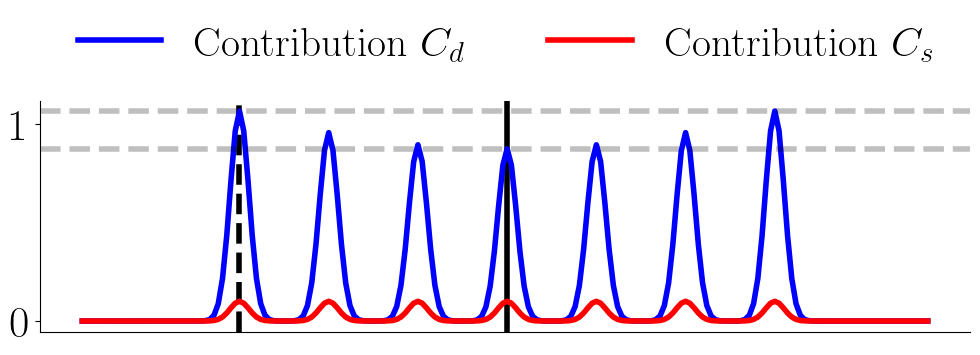

In [10]:
stims   = np.array([[-0.63,-0.42,-0.21,0,0.21,0.42,0.63],[0,0,0,0,0,0,0]])
lam = 1
Cs = 0.1
Cd = 2
xMax = 1

dx = 0.01
x = np.arange(-xMax,xMax,dx)
xplot = 6.66*x

C1  = np.zeros_like(x) 
C2  = np.zeros_like(x) 

Cd = initC(stims,Cd,lam)

for xs,c in zip(stims[0],Cd):
    C1 += (Cs)*np.exp(-1000*(x-xs)**2)
    C2 += (Cs+c)*np.exp(-1000*(x-xs)**2)
    
fig,ax = plt.subplots(figsize=(12,3))
plt.axvline(stims[0,0]*6.66,lw=4,c='k',ls='--')
plt.axvline(0,lw=4,c='k',ls='-')
plt.plot(xplot,C2,lw=4,c='b',label='Contribution $C_d$')
plt.plot(xplot,C1,lw=4,c='r',label='Contribution $C_s$')
#for s in stims[0]:
#    plt.axvline(s*6.66,c='k',lw=4,ls='--',alpha=0.25)
plt.axhline(C2.max(),c='k',lw=4,ls='--',alpha=0.25)
plt.axhline(C2[100],c='k',lw=4,ls='--',alpha=0.25)
leg =plt.legend(fontsize=30,loc=3,ncol=3,bbox_to_anchor=(0.,1))
leg.get_frame().set_linewidth(0.0)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.get_ylim()
plt.xticks([])

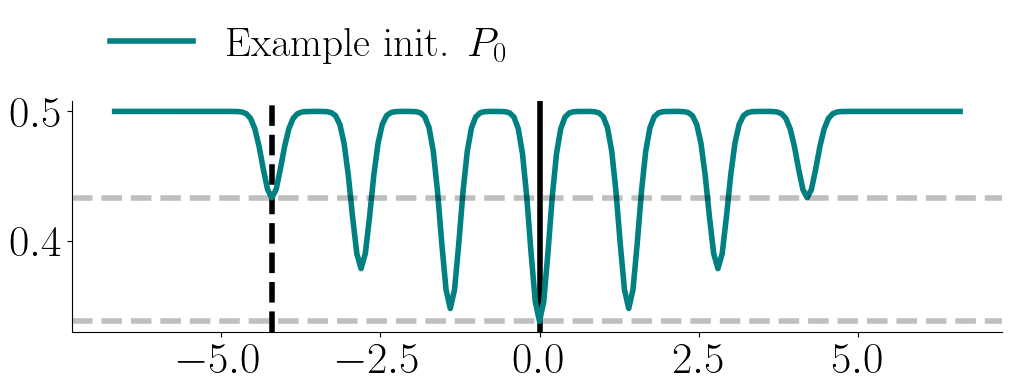

In [11]:
stims   = np.array([[-0.63,-0.42,-0.21,0,0.21,0.42,0.63],[0,0,0,0,0,0,0]])
lam = 1
Cs = 0.1
Cd = 2
xMax = 1

dx = 0.01
x = np.arange(-xMax,xMax,dx)
xplot = 6.66*x

C1  = np.zeros_like(x) 
C2  = np.zeros_like(x) 

C3 = np.ones_like(x)
Cd = initC(stims,Cd,lam)
Cd = 1-Cd

for xs,c in zip(stims[0],Cd):
    C1 += (Cs)*np.exp(-1000*(x-xs)**2)
    C2 += (Cs+c)*np.exp(-1000*(x-xs)**2)
    
fig,ax = plt.subplots(figsize=(12,3))
plt.axvline(stims[0,0]*6.66,lw=4,c='k',ls='--')
plt.axvline(0,lw=4,c='k',ls='-')
plt.plot(xplot,0.5*(1-C2),lw=4,c='teal',label='Example init. $P_0$')

#plt.plot(xplot,C1,lw=4,c='r',label='Contribution $C_s$')
plt.axhline(0.5*(1-C2).min(),c='k',lw=4,ls='--',alpha=0.25)
plt.axhline(0.5*(1-C2)[37],c='k',lw=4,ls='--',alpha=0.25)
leg =plt.legend(fontsize=30,loc=3,ncol=3,bbox_to_anchor=(0.,1))
leg.get_frame().set_linewidth(0.0)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.get_ylim()

## h

100%|██████████████████████████████████| 16001/16001 [00:00<00:00, 16208.85it/s]


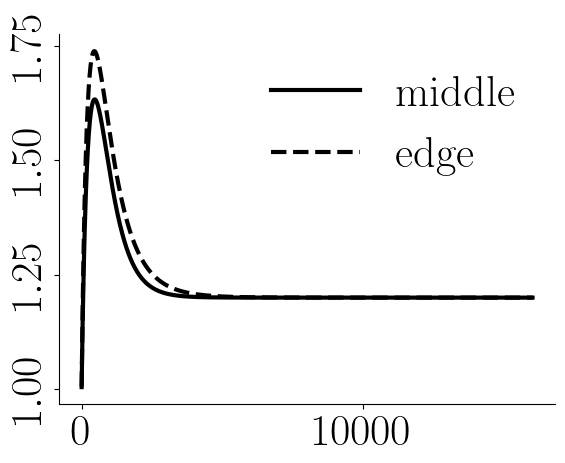

In [12]:
cPar  = [0.001,1]
p0Par = [0.01,1]
pPar  = [0.01,0.01,8]
zeta  = 1
phi   = 1
nu    = 1.2
stims   = np.array([[-0.63,-0.42,-0.21,0,0.21,0.42,0.63],[0,0,0,0,0,0,0]])
Cs = 0.1
S = RunSimul2(cPar,p0Par,pPar,zeta,phi,nu,stims)

fig,ax = plt.subplots()
plt.plot(S[:,200],lw=3,c='k',label='middle')
plt.plot(S[:,137],lw=3,c='k',ls='--',label='edge')
plt.legend(fontsize=32,frameon=False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.yticks(rotation=90,ha='right',va='center')

# Figure 2

In [13]:
SpineDir = DatDir+'3Spine/'
m,d = LoadThreeSpine(SpineDir,True)
mtot = np.hstack(m)
mtot3 = np.copy(mtot)
SpineDir = DatDir+'3SpineS/'
mS,d = LoadThreeSpine(SpineDir,False)

100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1633.30it/s]


[Errno 20] Not a directory: './DataProcessed/3Spine/.DS_Store/Spine/Synapse_l.json'


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 2645.64it/s]

[Errno 20] Not a directory: './DataProcessed/3SpineS/.DS_Store/Spine/Synapse_l.json'


## d

In [14]:
params = np.load(DatDir+'ModelFit/ControlFit3.npy')

a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_three = np.array([[-0.19,0,0.19],[0,0,0]])

SpineWidth = 1000
SM3 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_three)
SM3.Simulate()
xvec = SM3.x.round(2)
stimlocs_three = [np.argwhere(xvec == s)[0,0] for s in stims_three[0]]


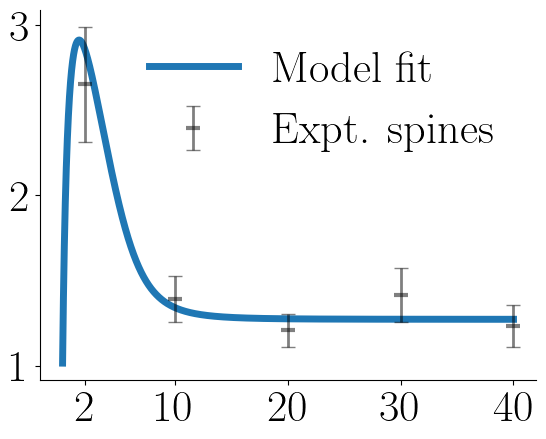

In [16]:
plt.plot(SM3.tvec,(SM3.S_tot[:,stimlocs_three[0]]
                   +SM3.S_tot[:,stimlocs_three[1]]+SM3.S_tot[:,stimlocs_three[2]])/3,lw=5,
         label='Model fit')
ax = plt.gca()
_,caps,_ = ax.errorbar([2,10,20,30,40],mtot[3:].mean(axis=1),stats.sem(mtot[3:],axis=1),
             capsize=5,ls='none',marker='_',ecolor='k',
             c='k',elinewidth=2,ms=10,mew=3,capthick=1,label='Expt. spines',alpha=0.5
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
leg = ax.legend(framealpha=0.5,fontsize=32)
leg.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40],[2,10,20,30,40])

## e

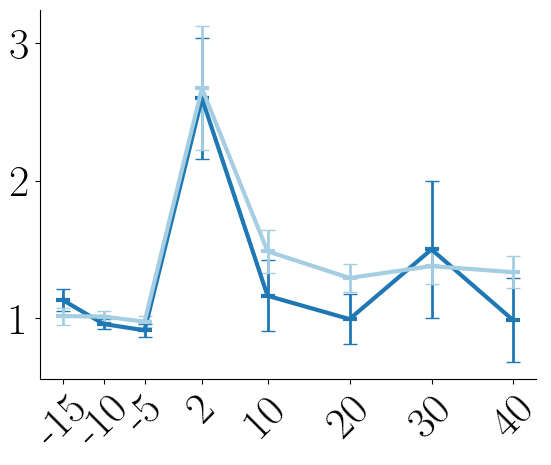

In [17]:
fig,ax = plt.subplots()
_,caps,_ = ax.errorbar([-15,-10,-5,2,10,20,30,40],m[0].mean(axis=1),stats.sem(m[0],axis=1),
             capsize=5,lw=3,marker='_',ecolor=C[ColorDict['Control']],
             c=C[ColorDict['Control']],elinewidth=2,ms=10,mew=3,capthick=1
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
    
_,caps,_ = ax.errorbar([-15,-10,-5,2,10,20,30,40],m[1].mean(axis=1),stats.sem(m[1],axis=1),
             capsize=5,lw=3,marker='_',ecolor=C[ColorDict['Control']-1],
             c=C[ColorDict['Control']-1],elinewidth=2,ms=10,mew=3,capthick=1
            )   
for cap in caps:
    cap.set_markeredgewidth(1)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([-15,-10,-5,2,10,20,30,40],[-15,-10,-5,2,10,20,30,40],rotation=45)
plt.show()

## f

(0.5548009922104938, 3.2444933533858356)

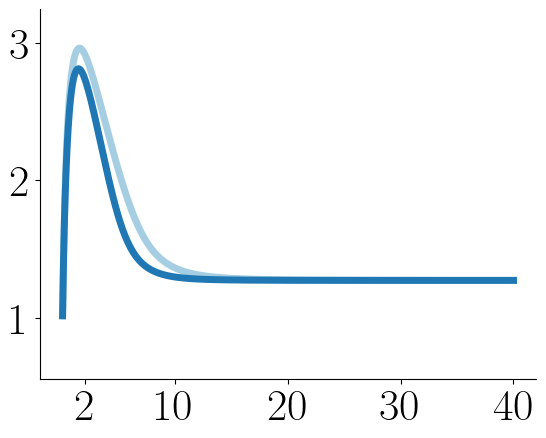

In [18]:
plt.plot(SM3.tvec,SM3.S_tot[:,stimlocs_three[0]],c=C[ColorDict['Control']-1],lw=5)
plt.plot(SM3.tvec,SM3.S_tot[:,stimlocs_three[1]],c=C[ColorDict['Control']],lw=5)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40],[2,10,20,30,40])
ax.set_ylim((0.5548009922104938, 3.2444933533858356))

## g

Ttest_indResult(statistic=4.428958747604943, pvalue=0.001649640898913982)
Ttest_indResult(statistic=3.9152901230596684, pvalue=0.0007413512251247523)


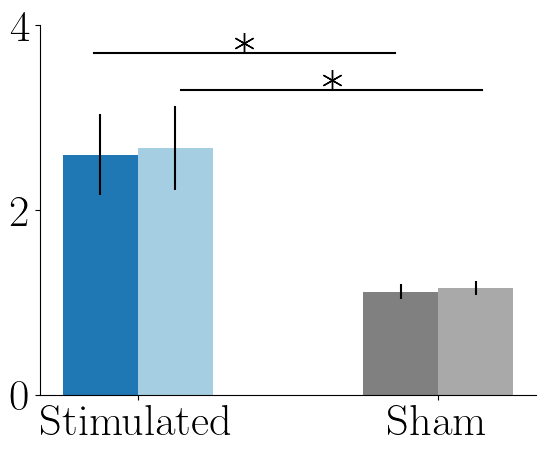

In [19]:
plt.bar([0],np.mean(m[0][3]),yerr=stats.sem(m[0][3]),width=0.25,color=C[ColorDict['Control']])
plt.bar([0.25],np.mean(m[1][3]),yerr=stats.sem(m[1][3]),width=0.25,color=C[ColorDict['Control']-1])

plt.plot([-0.02,0.98],[3.7,3.7],c='k')
print(stats.ttest_ind(m[0][3],mS[0][3]))
plt.plot(0.48,3.81,marker=(6, 2, 0),c='k',ms=15)
print(stats.ttest_ind(m[1][3],mS[1][3]))

plt.plot([0.27,1.27],[3.3,3.3],c='k')
plt.plot(0.77,3.41,marker=(6, 2, 0),c='k',ms=15)

plt.bar([1],np.mean(mS[0][3]),yerr=stats.sem(mS[0][3]),width=0.25,color=C[ColorDict['Sham']])
plt.bar([1.25],np.mean(mS[1][3]),yerr=stats.sem(mS[1][3]),width=0.25,color=C[ColorDict['Sham']-1])
plt.xticks([0.125,1.125],['Stimulated','Sham'],fontsize=32)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## h

Ttest_indResult(statistic=-0.4890556237368723, pvalue=0.6364993025678687)
Ttest_indResult(statistic=2.5727914873421245, pvalue=0.017359028724466312)


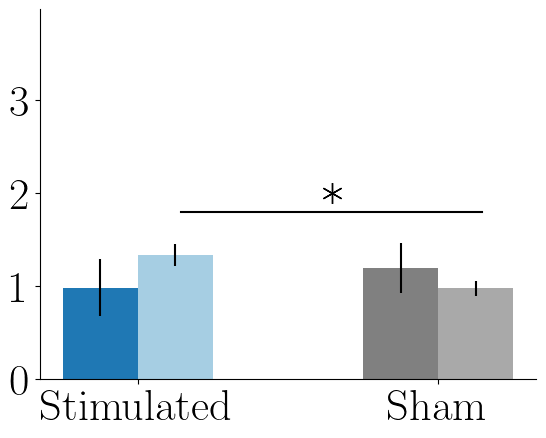

In [20]:
plt.bar([0],np.mean(m[0][-1]),yerr=stats.sem(m[0][-1]),width=0.25,color=C[ColorDict['Control']])
plt.bar([0.25],np.mean(m[1][-1]),yerr=stats.sem(m[1][-1]),width=0.25,color=C[ColorDict['Control']-1])

plt.plot([0.27,1.27],[1.8,1.8],c='k')
print(stats.ttest_ind(m[0][-1],mS[0][-1]))
plt.plot(0.77,2,marker=(6, 2, 0),c='k',ms=15)
print(stats.ttest_ind(m[1][-1],mS[1][-1]))

plt.bar([1],np.mean(mS[0][-1]),yerr=stats.sem(mS[0][-1]),width=0.25,color=C[ColorDict['Sham']])
plt.bar([1.25],np.mean(mS[1][-1]),yerr=stats.sem(mS[1][-1]),width=0.25,color=C[ColorDict['Sham']-1])
plt.xticks([0.125,1.125],['Stimulated','Sham'],fontsize=32)
plt.ylim((0.0, 3.9795))
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## i

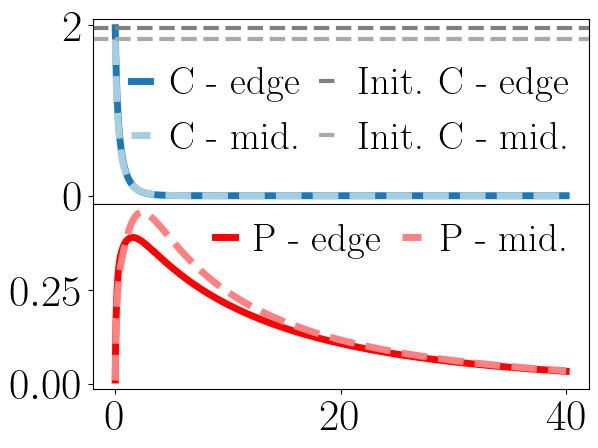

In [21]:
fig,ax = plt.subplots(2,1,figsize=(6.4,4.8))
plt.subplots_adjust(wspace=0, hspace=0)
ax[0].set_xticks([])
ax[0].plot(SM3.tvec,SM3.C_tot[:,stimlocs_three[0]],
         c=C[ColorDict['Control']],lw=5,label='C - edge')
ax[0].plot(SM3.tvec,SM3.C_tot[:,stimlocs_three[1]],
         c=C[ColorDict['Control']-1],lw=5,label='C - mid.',ls='--')
ax[0].axhline(SM3.C_tot[0,stimlocs_three[0]],lw=3,ls='--',c=C[ColorDict['Sham']],label='Init. C - edge')
ax[0].axhline(SM3.C_tot[0,stimlocs_three[1]],lw=3,c=C[ColorDict['Sham']-1],ls='--',label='Init. C - mid.')

ax[0].legend(ncols=2,fontsize=28,loc=5,frameon=False,handlelength=0.5,borderpad=0.0,
             handletextpad=0.5,columnspacing=0.5)
ax[1].plot(SM3.tvec,SM3.zeta2*SM3.P_tot[:,stimlocs_three[0]],
         c=[1,0,0],lw=5,label='P - edge')
ax[1].plot(SM3.tvec,SM3.zeta2*SM3.P_tot[:,stimlocs_three[1]],
         c=[1,0.5,0.5],lw=5,label='P - mid.',ls='--')
ax[1].legend(ncols=2,fontsize=28,frameon=False,handlelength=0.5,borderpad=0.0,
             handletextpad=0.5,columnspacing=0.5)

# Figure 3

In [22]:
SpineDir = DatDir+'/1Spine/'
mt= LoadOneSpine(SpineDir,True)
SpineDir = DatDir+'/1SpineCalc/'
m= LoadOneSpine(SpineDir,True)
SpineDir = DatDir+'/1SpineCam/'
m2= LoadOneSpine(SpineDir,False)
SpineDir = DatDir+'/1SpineS/'
m3= LoadOneSpine(SpineDir,False)
mt1 = np.copy(mt)

100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 1871.44it/s]


.DS_Store
[Errno 20] Not a directory: './DataProcessed//1Spine/.DS_Store/Spine/Synapse_l.json'
Index.txt
[Errno 20] Not a directory: './DataProcessed//1Spine/Index.txt/Spine/Synapse_l.json'
cell_1
cell_6
cell_8
cell_9
cell_7
cell_3
cell_4


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 2072.87it/s]


.DS_Store
[Errno 20] Not a directory: './DataProcessed//1SpineCalc/.DS_Store/Spine/Synapse_l.json'
cell_1
cell_6
cell_5
cell_2
cell_3
cell_4


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 2477.02it/s]


.DS_Store
[Errno 20] Not a directory: './DataProcessed//1SpineCam/.DS_Store/Spine/Synapse_l.json'
cell_1
cell_6
cell_8
cell_7
cell_5
cell_2


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 1805.28it/s]

cell_15
cell_12
cell_13
cell_14
.DS_Store
[Errno 20] Not a directory: './DataProcessed//1SpineS/.DS_Store/Spine/Synapse_l.json'
cell_1
cell_9
cell_7
cell_16
cell_19
cell_17
cell_5
cell_3
cell_4


In [23]:
params = np.load(DatDir+'ModelFit/ControlFit3.npy')


a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]*3
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]/2

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_one   = np.array([[0],[0]])

SpineWidth = 1000
SM1 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_one)
SM1.Simulate()

## d

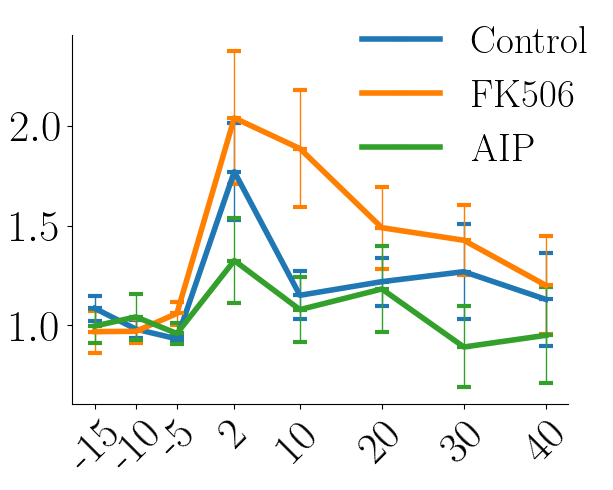

In [24]:
_,caps,_ = plt.errorbar(Fulltimes,np.nanmean(mt,axis=1),stats.sem(mt,axis=1,nan_policy='omit'),
             capsize=5,marker='_',ecolor=C[ColorDict['Control']],label='Control',
             c=C[ColorDict['Control']],elinewidth=1,ms=10,mew=3,capthick=1,lw=lw
            )   
_,caps,_ = plt.errorbar(Fulltimes,np.mean(m,axis=1),stats.sem(m,axis=1),
             capsize=5,marker='_',ecolor=C[ColorDict['Calcineurin']],
             c=C[ColorDict['Calcineurin']],elinewidth=1,ms=10,mew=3,capthick=1,lw=lw,label='FK506'
            )   
_,caps,_ = plt.errorbar(Fulltimes,np.mean(m2,axis=1),stats.sem(m2,axis=1),
             capsize=5,marker='_',ecolor=C[ColorDict['CamKII']],
             c=C[ColorDict['CamKII']],elinewidth=1,ms=10,mew=3,capthick=1,lw=lw,label='AIP'
            )   
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# get handles
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
leg = ax.legend(handles, labels, framealpha=0.5,fontsize=28,loc=1,bbox_to_anchor=(1.11,1.12))
leg.get_frame().set_linewidth(0.0)
ax.set_xticks([-15,-10,-5,2,10,20,30,40],[-15,-10,-5,2,10,20,30,40],rotation=45)

## e

Ttest_indResult(statistic=5.327153443406927, pvalue=8.45750696434919e-05)
Ttest_indResult(statistic=4.624040280567739, pvalue=0.00024233052272289513)
Ttest_indResult(statistic=-0.5871327913728718, pvalue=0.5733071215748596)
Ttest_indResult(statistic=2.1716042478143676, pvalue=0.04432779004466877)


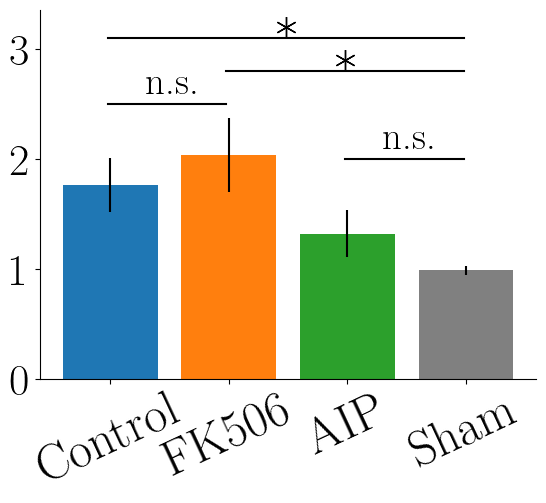

In [25]:
plt.bar([0],np.mean(mt[3]),yerr=stats.sem(mt[3]))
plt.bar([1],np.mean(m[3]),yerr=stats.sem(m[3]))
plt.bar([2],np.mean(m2[3]),yerr=stats.sem(m2[3]))
plt.bar([3],np.mean(m3[3]),yerr=stats.sem(m3[3]),color=C[ColorDict['Sham']])
plt.plot([-0.02,0.98],[2.5,2.5],c='k')
print(stats.ttest_ind(mt[3],m3[3]))
plt.plot([0.98,2.98],[2.8,2.8],c='k')
print(stats.ttest_ind(m[3],m3[3]))
plt.plot([-0.02,2.98],[3.1,3.1],c='k')
print(stats.ttest_ind(mt[3],m[3]))
plt.plot([1.98,2.98],[2.,2.],c='k')
print(stats.ttest_ind(m2[3],m3[3]))
plt.text(0.3,2.6,'n.s.',fontsize=28)
plt.text(2.3,2.1,'n.s.',fontsize=28)
plt.plot(1.48,3.2,marker=(6, 2, 0),c='k',ms=15)
plt.plot(1.98,2.9,marker=(6, 2, 0),c='k',ms=15)
plt.xticks([0,1,2,3],['Control','FK506','AIP','Sham'],rotation=25,fontsize=36)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## f

Ttest_indResult(statistic=2.229412412543613, pvalue=0.04149493541405128)
Ttest_indResult(statistic=2.380200932556023, pvalue=0.029274287460066564)
Ttest_indResult(statistic=-0.19644470761686772, pvalue=0.8491606858742807)
Ttest_indResult(statistic=1.0644905180054436, pvalue=0.30199342908107735)


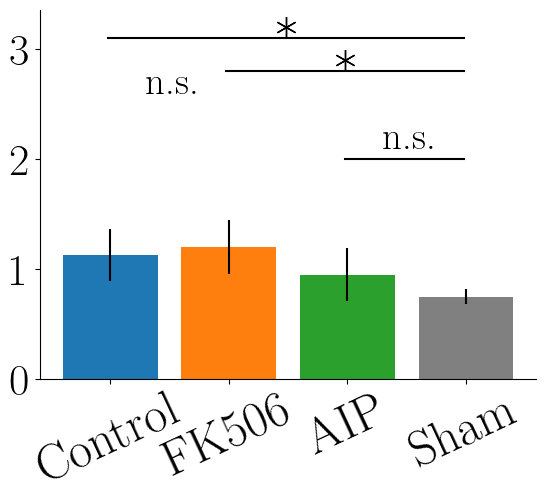

In [26]:
plt.bar([0],np.mean(mt[-1]),yerr=stats.sem(mt[-1]))
plt.bar([1],np.mean(m[-1]),yerr=stats.sem(m[-1]))
plt.bar([2],np.mean(m2[-1]),yerr=stats.sem(m2[-1]))
plt.bar([3],np.mean(m3[-1]),yerr=stats.sem(m3[-1]),color=C[ColorDict['Sham']])
print(stats.ttest_ind(mt[-1],m3[-1]))
plt.plot([0.98,2.98],[2.8,2.8],c='k')
print(stats.ttest_ind(m[-1],m3[-1]))
plt.plot([-0.02,2.98],[3.1,3.1],c='k')
print(stats.ttest_ind(mt[-1],m[-1]))
plt.plot([1.98,2.98],[2.,2.],c='k')
print(stats.ttest_ind(m2[-1],m3[-1]))
plt.text(0.3,2.6,'n.s.',fontsize=28)
plt.text(2.3,2.1,'n.s.',fontsize=28)
plt.plot(1.48,3.2,marker=(6, 2, 0),c='k',ms=15)
plt.plot(1.98,2.9,marker=(6, 2, 0),c='k',ms=15)
plt.xticks([0,1,2,3],['Control','FK506','AIP','Sham'],rotation=25,fontsize=36)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## g

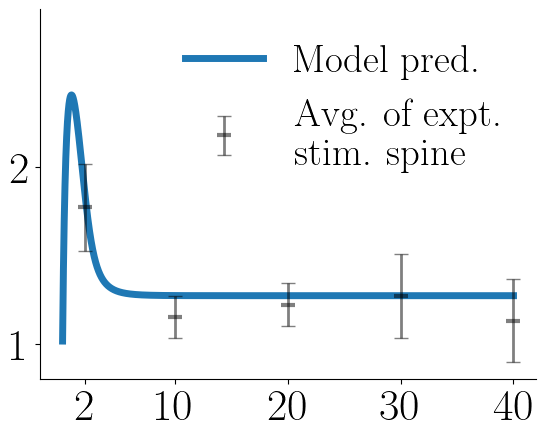

In [51]:
plt.plot(SM1.tvec,SM1.S_tot[:,stimlocs_three[1]],c=C[ColorDict['Control']],lw=5,label=r'Model pred.')
ax = plt.gca()
_,caps,_ = ax.errorbar([2,10,20,30,40],np.nanmean(mt[3:],axis=1),stats.sem(mt[3:],axis=1,nan_policy='omit'),
             capsize=5,ls='none',marker='_',ecolor='k',
             c='k',elinewidth=2,ms=10,mew=3,capthick=1,label='Avg. of expt.\n stim. spine',alpha=0.5
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
leg = ax.legend(framealpha=0.5,fontsize=28,loc=1,bbox_to_anchor=(1,1.0))
leg.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40])
ax.set_ylim((0.8019776806368575, 2.8876038980241576))

## h

In [32]:
params = np.load(DatDir+'ModelFit/ControlFit1Calc.npy')


a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_one   = np.array([[0],[0]])

SpineWidth = 1000

SMCalc = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],
                   [lam,mu,Cs,Cd],tMax,xMax,stims_one)
SMCalc.Simulate()


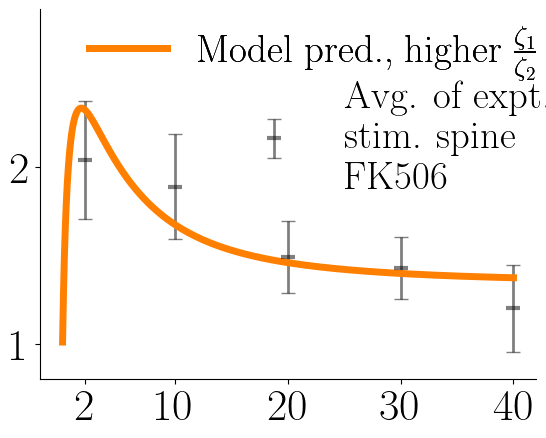

In [52]:

p1 ,caps,_ = plt.errorbar([2,10,20,30,40],np.nanmean(m[3:],axis=1),stats.sem(m[3:],axis=1,nan_policy='omit'),
             capsize=5,ls='none',marker='_',ecolor='k',
             c='k',elinewidth=2,ms=10,mew=3,capthick=1,label='Avg. of expt.\n stim. spine \n FK506',alpha=0.5
            )   
p2 = plt.plot(SMCalc.tvec,SMCalc.S_tot[:,stimlocs_three[1]],c=C[ColorDict['Calcineurin']],lw=5,
         )
ax = plt.gca()
for cap in caps:
    cap.set_markeredgewidth(1)
leg = ax.legend(framealpha=0.0,fontsize=28,loc=1,bbox_to_anchor = (1.1,0.9))
#l1 = ax.legend([p1], ['Avg. of expt.\n stim. spine \n FK506'], loc=1,framealpha=0.5,fontsize=24)
l2 = ax.legend([p2[0]], [r'Model pred., higher $\frac{\zeta_1}{\zeta_2}$'], loc=1,framealpha=0.0,fontsize=28,
                bbox_to_anchor=(1.075,1.05))
leg.get_frame().set_linewidth(0.0)
l2.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.add_artist(leg)
ax.add_artist(l2)
ax.spines["top"].set_visible(False)
ax.set_ylim((0.8019776806368575, 2.8876038980241576))
ax.set_xticks([2,10,20,30,40])

In [79]:
params = np.load(DatDir+'ModelFit/ControlFit1Cam.npy')


a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_one   = np.array([[0],[0]])

SpineWidth = 1000

SMCam = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],
                   [lam,mu,Cs,Cd],tMax,xMax,stims_one)
SMCam.Simulate()


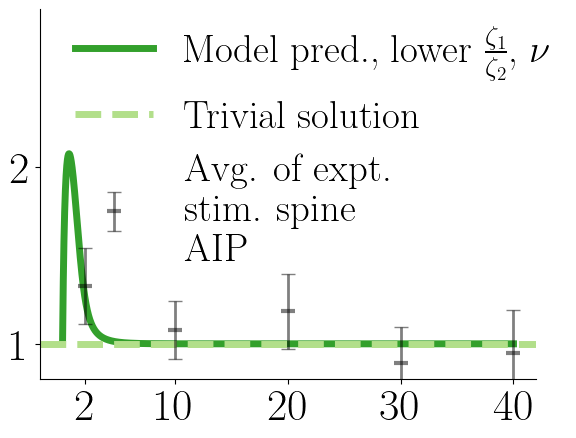

In [81]:
plt.plot(SMCam.tvec,SMCam.S_tot[:,stimlocs_three[1]],c=C[ColorDict['CamKII']],lw=5,
         label=r'Model pred., lower $\frac{\zeta_1}{\zeta_2}$, $\nu$')
plt.axhline(1,ls='--',c=C[ColorDict['CamKII']-1],lw=5,label='Trivial solution')
ax = plt.gca()
_,caps,_ = ax.errorbar([2,10,20,30,40],np.nanmean(m2[3:],axis=1),stats.sem(m2[3:],axis=1,nan_policy='omit'),
             capsize=5,ls='none',marker='_',ecolor='k',
             c='k',elinewidth=2,ms=10,mew=3,capthick=1,label='Avg. of expt.\n stim. spine \n AIP',alpha=0.5
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
leg = ax.legend(framealpha=0.0,fontsize=28,loc=1,bbox_to_anchor=(1.1,1.05))
leg.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylim((0.8019776806368575, 2.8876038980241576))
ax.set_xticks([2,10,20,30,40])

In [66]:
params = np.load(DatDir+'ModelFit/ControlFit1Cam.npy')


a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_one   = np.array([[0],[0]])

SpineWidth = 1000

SMCam = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],
                   [lam,mu,Cs,Cd],tMax,xMax,stims_one)
SMCam.Simulate()


In [ ]:
plt.plot(SMCam.tvec,SMCam.S_tot[:,stimlocs_three[1]],c=C[ColorDict['CamKII']],lw=5,
         label=r'Model pred., lower $\frac{\zeta_1}{\zeta_2}$, $\nu$')
plt.axhline(1,ls='--',c=C[ColorDict['CamKII']-1],lw=5,label='Trivial solution')
ax = plt.gca()
_,caps,_ = ax.errorbar([2,10,20,30,40],np.nanmean(m2[3:],axis=1),stats.sem(m2[3:],axis=1,nan_policy='omit'),
             capsize=5,ls='none',marker='_',ecolor='k',
             c='k',elinewidth=2,ms=10,mew=3,capthick=1,label='Avg. of expt.\n stim. spine \n AIP',alpha=0.5
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
leg = ax.legend(framealpha=0.0,fontsize=28,loc=1,bbox_to_anchor=(1.1,1.05))
leg.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylim((0.8019776806368575, 2.8876038980241576))
ax.set_xticks([2,10,20,30,40])

# Figure 4

In [82]:
SpineDir = DatDir+'7Spine/'
m,d,p = LoadSevenSpine3(SpineDir)
SType = []
for testd in d:
    stype = []
    for td in testd:
        if((testd-td <= 0).all() or (testd-td>=0).all()):
           stype.append('o')
        else:
            diff = testd-td
            p1 = diff[diff>0].min()
            p2 = diff[diff<0].max()
            if(p1>2 or p2 < -2):
                stype.append('e')
            else:
                stype.append('m')
    SType.append(stype)
SType = np.hstack(SType)

S = SType[[not p1 for p1 in p]]

mt7 = np.copy(m)

mtot7 = np.copy(mtot)
SpineDirSham = DatDir+'7SpineS/'
mS,dS = LoadSevenSpine2(SpineDirSham,False)
mtotS = np.hstack(mS)

SpineDir = DatDir+'7SpineD/'
mD,dD = LoadSevenSpine2(SpineDir)
mtotD = np.hstack(mD)

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 118.77it/s]


cell_12
.DS_Store
[Errno 20] Not a directory: './DataProcessed/7Spine/.DS_Store/Spine/Synapse_l.json'
Index.txt
[Errno 20] Not a directory: './DataProcessed/7Spine/Index.txt/Spine/Synapse_l.json'
cell_1
cell_6
cell_8
cell_9
cell_7
cell_11
cell_10
cell_5
cell_2
cell_3
cell_4


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 4201.87it/s]


cell_12
[Errno 2] No such file or directory: './DataProcessed/7SpineS/cell_12/Spine/Synapse_l.json'
cell_13
.DS_Store
[Errno 20] Not a directory: './DataProcessed/7SpineS/.DS_Store/Spine/Synapse_l.json'
Index.txt
[Errno 20] Not a directory: './DataProcessed/7SpineS/Index.txt/Spine/Synapse_l.json'
cell_1
cell_6
cell_9
cell_7
cell_10
cell_4


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 3831.37it/s]

.DS_Store
[Errno 20] Not a directory: './DataProcessed/7SpineD/.DS_Store/Spine/Synapse_l.json'
cell_1
cell_6
cell_8
cell_9
cell_11
cell_10
cell_5
cell_2
cell_3
cell_4


## d

In [83]:
params = np.load(DatDir+'ModelFit/ControlFit3.npy')

a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = 5*params[4]/7
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = 2.5*params[11]/7

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_one   = np.array([[0],[0]])
stims_seven   = np.array([[-0.63,-0.42,-0.21,0,0.21,0.42,0.63],[0,0,0,0,0,0,0]])

SpineWidth = 1000
stimlocs_seven = [np.argwhere(xvec == s)[0,0] for s in stims_seven[0]]


SM7 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_seven)
SM7.Simulate()

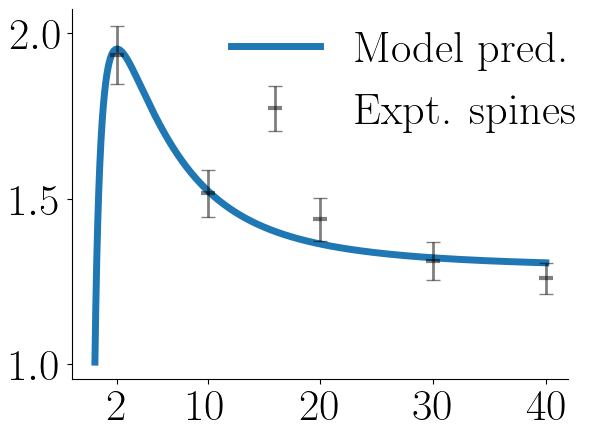

In [86]:
plt.plot(SM7.tvec,np.mean([SM7.S_tot[:,s] for s in stimlocs_seven],axis=0),lw=5
        ,label='Model pred.')
ax = plt.gca()
_,caps,_ = ax.errorbar([2,10,20,30,40],m[:,3:].mean(axis=0),stats.sem(m[:,3:],axis=0),
             capsize=5,ls='none',marker='_',ecolor='k',
             c='k',elinewidth=2,ms=10,mew=3,capthick=1,label='Expt. spines',alpha=0.5
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
    
    ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40])
leg = ax.legend(framealpha=0.5,fontsize=32,loc=1,bbox_to_anchor=(1.1,1.05))
leg.get_frame().set_linewidth(0.0)

## e

Ttest_indResult(statistic=10.451708449953822, pvalue=1.0141964925426403e-17)
Ttest_indResult(statistic=2.2464545377401737, pvalue=0.0268739076751666)


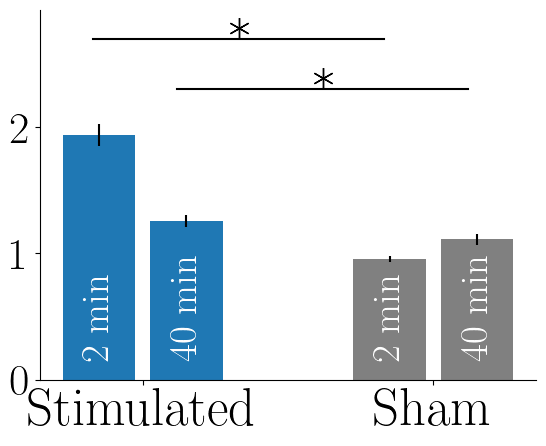

In [87]:
plt.bar([0],np.mean(m[:,3]),yerr=stats.sem(m[:,3]),width=0.25,color=C[ColorDict['Control']])
plt.bar([0.3],np.mean(m[:,-1]),yerr=stats.sem(m[:,-1]),width=0.25,color=C[ColorDict['Control']])

plt.bar([1],np.mean(mtotS[3]),yerr=stats.sem(mtotS[3]),width=0.25,color=C[ColorDict['Sham']])
plt.bar([1.3],np.mean(mtotS[-1]),yerr=stats.sem(mtotS[-1]),width=0.25,color=C[ColorDict['Sham']])


plt.plot([-0.02,0.98],[2.7,2.7],c='k')
print(stats.ttest_ind(m[:,3],mtotS[3]))
plt.plot(0.48,2.79,marker=(6, 2, 0),c='k',ms=15)

plt.plot([0.27,1.27],[2.3,2.3],c='k')
print(stats.ttest_ind(m[:,-1],mtotS[-1]))
plt.plot(0.77,2.39,marker=(6, 2, 0),c='k',ms=15)

plt.text(-0.06,0.2,'2 min',rotation=90,fontsize=28,color='w')
plt.text(0.3-0.06,0.2,'40 min',rotation=90,fontsize=28,color='w')

plt.text(1-0.06,0.2,'2 min',rotation=90,fontsize=28,color='w')
plt.text(1.3-0.06,0.2,'40 min',rotation=90,fontsize=28,color='w')
plt.xticks([0.15,1.15],['Stimulated','Sham'],fontsize=38)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## f

(0.9483729305222584, 2.3)

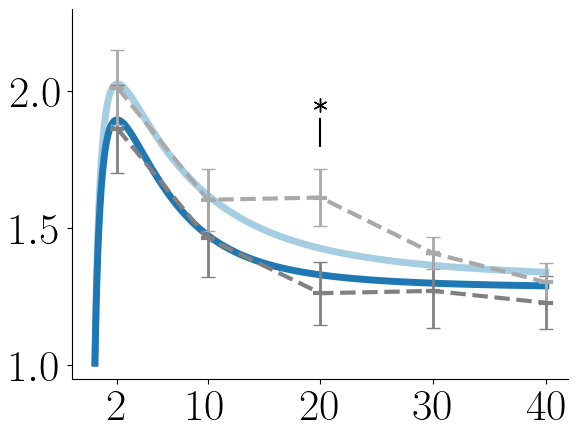

In [96]:
plt.plot(SM7.tvec,SM7.S_tot[:,stimlocs_seven[0]],c=C[ColorDict['Control']-1],lw=5)
plt.plot(SM7.tvec,SM7.S_tot[:,stimlocs_seven[3]],c=C[ColorDict['Control']],lw=5)
ax = plt.gca()
m1 = m[S=='m']
_,caps,_ = ax.errorbar([2,10,20,30,40],m1[:,3:].mean(axis=0),stats.sem(m1[:,3:],axis=0),
             capsize=5,lw=3,ls='--',marker='_',ecolor=C[ColorDict['Sham']],
             c=C[ColorDict['Sham']],elinewidth=2,ms=10,mew=3,capthick=1
            )   
for cap in caps:
    cap.set_markeredgewidth(1)

m2 = m[S=='e']
_,caps,_ = ax.errorbar([2,10,20,30,40],m2[:,3:].mean(axis=0),stats.sem(m2[:,3:],axis=0),
             capsize=5,lw=3,ls='--',marker='_',ecolor=C[ColorDict['Sham']-1],
             c=C[ColorDict['Sham']-1],elinewidth=2,ms=10,mew=3,capthick=1
            )   
for cap in caps:
    cap.set_markeredgewidth(1)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40])

plt.plot([20,20],[1.8,1.9],c='k')
plt.plot(20,1.95,marker=(6, 2, 0),c='k',ms=10)

ax.set_ylim(0.9483729305222584,2.3)


## g

In [90]:
mind = []
for d2 in d:
    dt = np.sort(d2)
    for i in range(len(dt)):
        mind.append(min(abs(dt[i]-dt[(i-1)%len(dt)]),abs(dt[(i+1)%len(dt)]-dt[i])))
mindD = []
for d2 in dD:
    dt = np.sort(d2)
    for i in range(len(dt)):
        mindD.append(min(abs(dt[i]-dt[(i-1)%len(dt)]),abs(dt[(i+1)%len(dt)]-dt[i])))

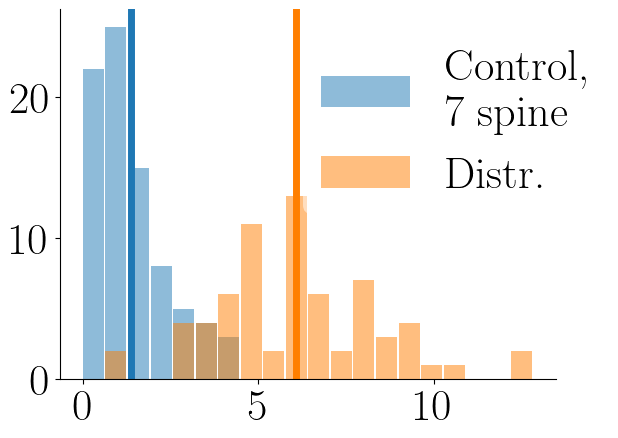

In [91]:
plt.hist(mind,alpha=0.5,width=0.6,range=(0,max(mindD)),bins=20,color=C[ColorDict['Control']],label='Control, \n 7 spine')
plt.hist(mindD,alpha=0.5,width=0.6,range=(0,max(mindD)),bins=20,color=C[ColorDict['Calcineurin']],label='Distr.')

plt.axvline(np.mean(mind),color=C[ColorDict['Control']],lw=5)
plt.axvline(np.mean(mindD),color=C[ColorDict['Calcineurin']],lw=5)
ax = plt.gca()
leg = ax.legend(framealpha=0.5,fontsize=32,loc=1,bbox_to_anchor=[1.15,1])
leg.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## h

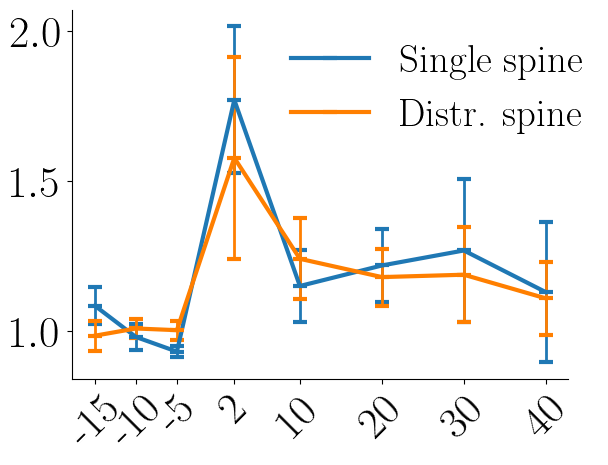

In [92]:
fig,ax = plt.subplots()
_,caps,_ = ax.errorbar([-15,-10,-5,2,10,20,30,40],mt.mean(axis=1),stats.sem(mt,axis=1),
         capsize=5,lw=3,marker='_',ecolor=C[ColorDict['Control']],
         c=C[ColorDict['Control']],elinewidth=2,ms=10,mew=3,capthick=1,label='Single spine'
        )   
_,caps,_ = ax.errorbar([-15,-10,-5,2,10,20,30,40],mtotD.mean(axis=1),stats.sem(mtot,axis=1),
         capsize=5,lw=3,marker='_',ecolor=C[ColorDict['Calcineurin']],
         c=C[ColorDict['Calcineurin']],elinewidth=2,ms=10,mew=3,capthick=1,label='Distr. spine'
        )   

handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
leg = ax.legend(handles, labels, framealpha=0.5,fontsize=28,loc=1,bbox_to_anchor=(1.1,1.))
leg.get_frame().set_linewidth(0.0)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([-15,-10,-5,2,10,20,30,40],[-15,-10,-5,2,10,20,30,40],rotation=45)

## i

In [94]:
params = np.load(DatDir+'ModelFit/ControlFit3.npy')
a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]*3
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]/2

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_one   = np.array([[0],[0]])

SpineWidth = 1000
SM1 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_one)
SM1.Simulate()

params = np.load(DatDir+'ModelFit/ControlDistr.npy')

a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_seven   = np.array([[-1.89,-1.26,-0.63,0,0.63,1.26,1.89],[0,0,0,0,0,0,0]])

SpineWidth = 1000
SM2 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_one)
SM2.Simulate()



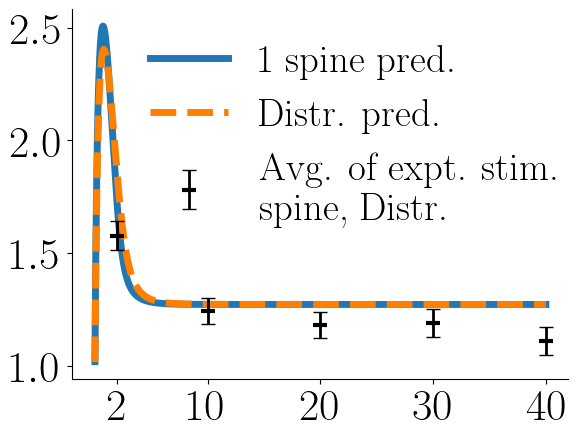

In [98]:
plt.plot(SM2.tvec,SM2.S_tot[:,stimlocs_three[1]],c=C[ColorDict['Control']],lw=5,label=r'1 spine pred.')
plt.plot(SM2.tvec,SM1.S_tot[:,stimlocs_three[1]],c=C[ColorDict['Calcineurin']],lw=5,label=r'Distr. pred.',ls='--')

ax = plt.gca()
_,caps,_ = ax.errorbar([2,10,20,30,40],mtotD[3:].mean(axis=1),stats.sem(mtotD[3:],axis=1),
             capsize=5,ls='none',marker='_',ecolor='k',
             c='k',elinewidth=2,ms=10,mew=3,capthick=1,label='Avg. of expt. stim.\n spine, Distr.'
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
leg = ax.legend(framealpha=0.5,fontsize=28,loc=1,bbox_to_anchor=(1.05,1))
leg.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40])

# Figure 5

In [99]:
SpineDir = DatDir+'15Spine/'
m,d = Load15Spine(SpineDir)
mtot = np.hstack(m)
mtot15 = np.copy(mtot)
SpineDir = DatDir+'15SpineS/'
ms,ds = Load15Spine(SpineDir,False)
mtots = np.hstack(m)

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 883.49it/s]


cell_15
[Errno 2] No such file or directory: './DataProcessed/15Spine/cell_15/Spine/Synapse_l.json'
cell_12
cell_13
cell_14
.DS_Store
[Errno 20] Not a directory: './DataProcessed/15Spine/.DS_Store/Spine/Synapse_l.json'
cell_1
cell_6
cell_9
cell_7
cell_11
cell_10
cell_5
cell_2
cell_3
cell_4


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 1979.28it/s]

.DS_Store
[Errno 20] Not a directory: './DataProcessed/15SpineS/.DS_Store/Spine/Synapse_l.json'
Index.txt
[Errno 20] Not a directory: './DataProcessed/15SpineS/Index.txt/Spine/Synapse_l.json'
cell_1
cell_6
[Errno 2] No such file or directory: './DataProcessed/15SpineS/cell_6/Spine/Synapse_l.json'
cell_7
cell_5
cell_2
[Errno 2] No such file or directory: './DataProcessed/15SpineS/cell_2/Spine/Synapse_l.json'
cell_3
cell_4
[Errno 2] No such file or directory: './DataProcessed/15SpineS/cell_4/Spine/Synapse_l.json'


In [100]:
params = np.load(DatDir+'ModelFit/ControlFit3.npy')
a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]/4
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]/15

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_one   = np.array([[0],[0]])
stims_seven   = np.array([[-0.63,-0.42,-0.21,0,0.21,0.42,0.63],[0,0,0,0,0,0,0]])
stims_fifteen = np.array([[-1.68,-1.44,-1.2,-0.96,-0.72,-0.48,-0.24,0,0.24,0.48,0.72,0.96,1.2,1.44,1.68],
                        [0]*15])
    
SpineWidth = 1000
stimlocs_seven = [np.argwhere(xvec == s)[0,0] for s in stims_seven[0]]
stimlocs_15 = [np.argwhere(xvec == s)[0,0] for s in stims_fifteen[0]]


SM15 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_fifteen)
SM15.Simulate()

## d

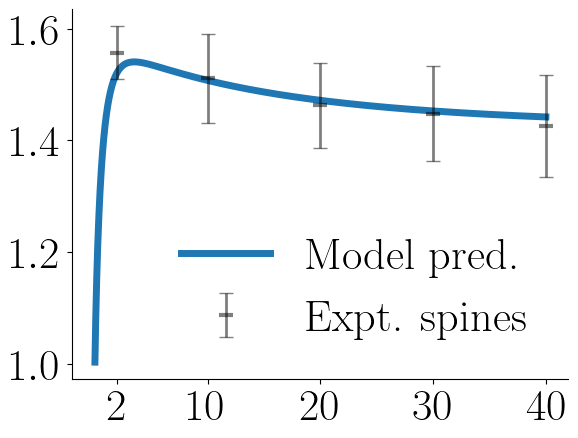

In [101]:
plt.plot(SM15.tvec,np.mean([SM15.S_tot[:,s] for s in stimlocs_15],axis=0),lw=5
        ,label='Model pred.')
ax = plt.gca()
_,caps,_ = ax.errorbar([2,10,20,30,40],mtot[3:].mean(axis=1),stats.sem(mtot[3:],axis=1),
             capsize=5,ls='none',marker='_',ecolor='k',
             c='k',elinewidth=2,ms=10,mew=3,capthick=1,label='Expt. spines',alpha=0.5
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
    
    ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40])
leg = ax.legend(framealpha=0.5,fontsize=32)
leg.get_frame().set_linewidth(0.0)

## e

Ttest_indResult(statistic=10.504627428040639, pvalue=3.3078352271875612e-18)
Ttest_indResult(statistic=2.8788173116598332, pvalue=0.004813155063703009)


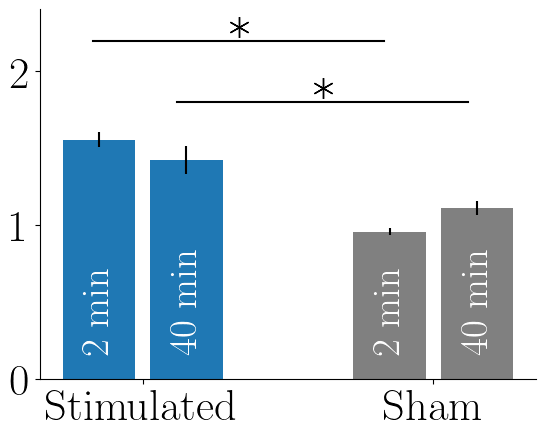

In [102]:
plt.bar([0],np.mean(mtot[3]),yerr=stats.sem(mtot[3]),width=0.25,color=C[ColorDict['Control']])
plt.bar([0.3],np.mean(mtot[-1]),yerr=stats.sem(mtot[-1]),width=0.25,color=C[ColorDict['Control']])

plt.bar([1],np.mean(mtotS[3]),yerr=stats.sem(mtotS[3]),width=0.25,color=C[ColorDict['Sham']])
plt.bar([1.3],np.mean(mtotS[-1]),yerr=stats.sem(mtotS[-1]),width=0.25,color=C[ColorDict['Sham']])


plt.plot([-0.02,0.98],[2.2,2.2],c='k')
print(stats.ttest_ind(mtot[3],mtotS[3]))
plt.plot(0.48,2.29,marker=(6, 2, 0),c='k',ms=15)

plt.plot([0.27,1.27],[1.8,1.8],c='k')
print(stats.ttest_ind(mtot[-1],mtotS[-1]))
plt.plot(0.77,1.89,marker=(6, 2, 0),c='k',ms=15)

plt.text(-0.06,0.2,'2 min',rotation=90,fontsize=28,color='w')
plt.text(0.3-0.06,0.2,'40 min',rotation=90,fontsize=28,color='w')

plt.text(1-0.06,0.2,'2 min',rotation=90,fontsize=28,color='w')
plt.text(1.3-0.06,0.2,'40 min',rotation=90,fontsize=28,color='w')
plt.xticks([0.15,1.15],['Stimulated','Sham'],fontsize=32)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


In [103]:
C1 = SM1.zeta1*np.sum(SM1.C_tot[:,200])*SM1.dt
Pact1  = SM1.P_tot[:,200]*SM1.F(SM1.S_tot[:,200])
Pp1 = SM1.zeta2*np.sum(Pact1[Pact1>0])*SM1.dt
Pm1 = SM1.zeta2*np.sum(Pact1[Pact1<0])*SM1.dt

C3 = SM3.zeta1*np.sum([SM3.C_tot[:,s] for s in stimlocs_three],axis=1).mean()*SM1.dt
Pact3  = np.mean([SM3.P_tot[:,s]*SM3.F(SM3.S_tot[:,s]) for s in stimlocs_three],axis=0)
Pp3 = SM3.zeta2*np.sum(Pact3[Pact3>0])*SM1.dt
Pm3 = SM3.zeta2*np.sum(Pact3[Pact3<0])*SM1.dt

C7 = SM7.zeta1*np.sum([SM7.C_tot[:,s] for s in stimlocs_seven],axis=1).mean()*SM1.dt
Pact7  = np.mean([SM7.P_tot[:,s]*SM7.F(SM7.S_tot[:,s]) for s in stimlocs_seven],axis=0)
Pp7 = SM7.zeta2*np.sum(Pact7[Pact7>0])*SM1.dt
Pm7 = SM7.zeta2*np.sum(Pact7[Pact7<0])*SM1.dt

C15 = SM15.zeta1*np.sum([SM15.C_tot[:,s] for s in stimlocs_15],axis=1).mean()*SM1.dt
Pact15  = np.mean([SM15.P_tot[:,s]*SM15.F(SM15.S_tot[:,s]) for s in stimlocs_15],axis=0)
Pp15 = SM15.zeta2*np.sum(Pact15[Pact15>0])*SM1.dt
Pm15 = SM15.zeta2*np.sum(Pact15[Pact15<0])*SM1.dt

## f

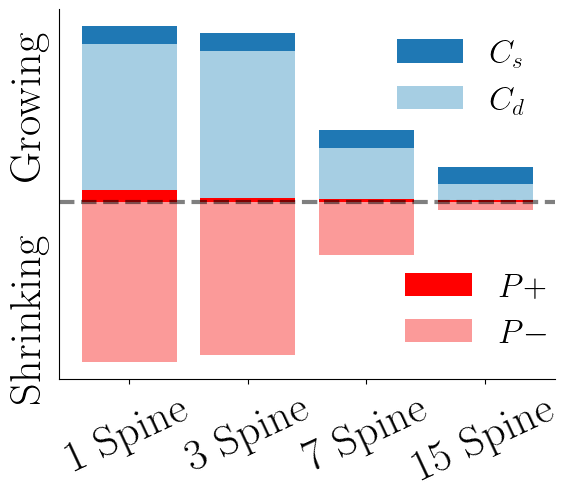

In [116]:
p1 =plt.bar([1,2,3,4],[Pp1+C1,Pp3+C3,
                   Pp7+C7,Pp15+C15]
       ,label = r'$C_d$',color=C[ColorDict['Control']])
p2 =plt.bar([1,2,3,4],[Pp1+C1-SM3.C_s,Pp3+C3-SM3.C_s,
                   Pp7+C7-SM7.C_s,Pp15+C15-SM15.C_s]
       ,label = r'$C_d$',color=C[ColorDict['Control']-1])
p3 =plt.bar([1,2,3,4],[Pp1*100,Pp3*100,
                   Pp7*100,Pp15*100]
       ,label = r'I$C_d$',color='r')

p4 =plt.bar([1,2,3,4],[Pm1,Pm3,
                   Pm7,Pm15]
       ,label = r'Init. $C_d$',color=C[ColorDict['CHX']-1])
plt.axhline(0,ls='--',lw=3,c='k',alpha=0.5)
plt.yticks([-0.75,2.5],['Shrinking','Growing'],rotation=90)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,        # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
plt.xticks([1,2,3,4],['1 Spine', '3 Spine','7 Spine','15 Spine'],rotation=25)
ax = plt.gca()
l1 = plt.legend([p1,p2], [r"$C_s$",r'$C_d$'], loc=1,framealpha=0.5,fontsize=24)
l2 = plt.legend([p3,p4], [r'$P+$',r'$P-$'], loc=4,framealpha=0.5,fontsize=24,
                bbox_to_anchor=(1.05,0))
ax.add_artist(l1)
l1.get_frame().set_linewidth(0.0)
l2.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## g

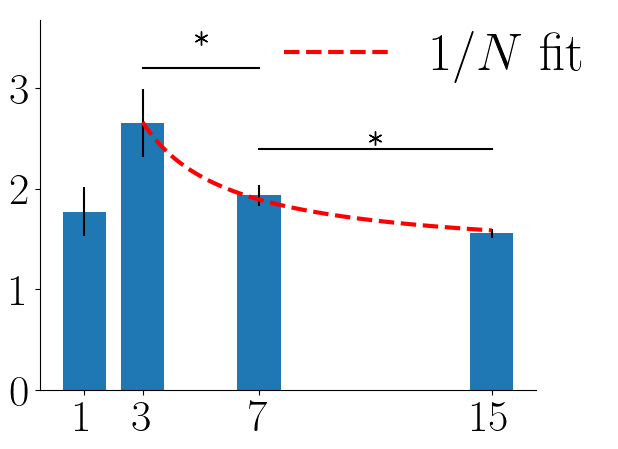

In [106]:
plt.bar([1],np.mean(mt1[3]),yerr=stats.sem(mt1[3]),color=C[ColorDict['Control']],width=1.5)
plt.bar([3],np.mean(mtot3[3]),yerr=stats.sem(mtot3[3]),color=C[ColorDict['Control']],width=1.5)
plt.bar([7],np.mean(mt7[:,3]),yerr=stats.sem(mt7[3]),color=C[ColorDict['Control']],width=1.5)
plt.bar([15],np.mean(mtot15[3]),yerr=stats.sem(mtot15[3]),color=C[ColorDict['Control']],width=1.5)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.plot([3,7],[3.2,3.2],c='k')
ax.plot([7,15],[2.4,2.4],c='k')
ax.plot(5,3.5,marker=(6, 2, 0),c='k',ms=10)
ax.plot(11,2.5,marker=(6, 2, 0),c='k',ms=10)
ax.set_xticks([1,3,7,15],[1,3,7,15],fontsize=32)
plt.plot(np.linspace(3,15,100),func(np.linspace(3,15,100),4.03624379, 1.3170679),lw=3,c='r',
         label=r'1/$N$ fit',ls='--')
leg = ax.legend(framealpha=0.0,fontsize=38,loc=1,bbox_to_anchor=(1.2,1.1))
leg.get_frame().set_linewidth(0.0)

## h

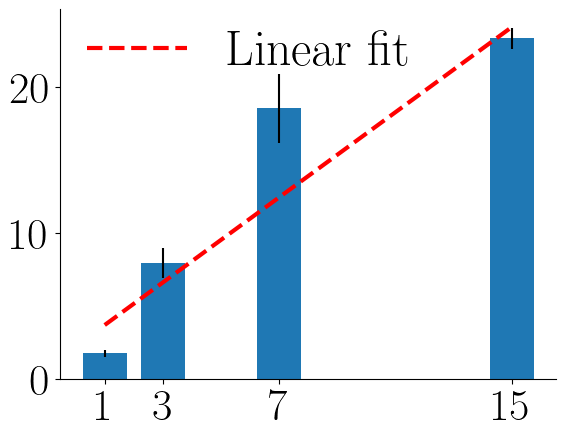

In [107]:
plt.bar([1],np.mean(mt1[3]),yerr=stats.sem(mt1[3]),color=C[ColorDict['Control']],width=1.5)
plt.bar([3],np.mean(mtot3[3])*3,yerr=stats.sem(mtot3[3])*3,color=C[ColorDict['Control']],width=1.5)
plt.bar([7],np.mean(mtot7[3])*7,yerr=stats.sem(mtot7[3])*7,color=C[ColorDict['Control']],width=1.5)
plt.bar([15],np.mean(mtot15[3])*15,yerr=stats.sem(mtot15[3])*15,color=C[ColorDict['Control']],width=1.5)
plt.plot([1,3,7,15],np.array([1,3,7,15])*1.45957126+2.2341839549489695,lw=3,c='r',ls='--',label='Linear fit')
plt.xticks([1,3,7,15])
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
leg = ax.legend(framealpha=0.0,fontsize=36,loc=4,bbox_to_anchor=(0.8,0.7))
leg.get_frame().set_linewidth(0.0)

## i

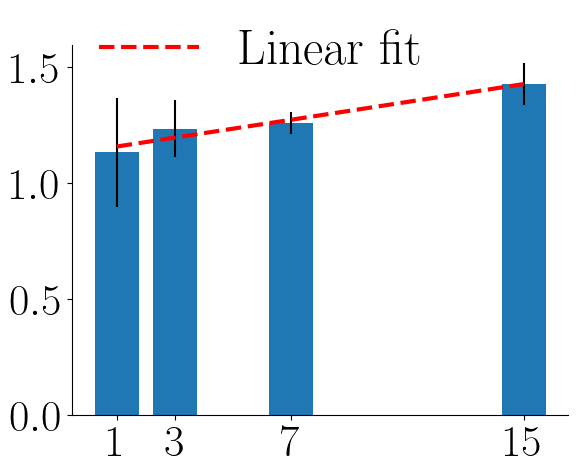

In [108]:
plt.bar([1],np.mean(mt1[-1]),yerr=stats.sem(mt1[-1]),color=C[ColorDict['Control']],width=1.5)
plt.bar([3],np.mean(mtot3[-1]),yerr=stats.sem(mtot3[-1]),color=C[ColorDict['Control']],width=1.5)
plt.bar([7],np.mean(mt7[:,-1]),yerr=stats.sem(mt7[:,-1]),color=C[ColorDict['Control']],width=1.5)
plt.bar([15],np.mean(mtot15[-1]),yerr=stats.sem(mtot15[-1]),color=C[ColorDict['Control']],width=1.5)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([1,3,7,15],[1,3,7,15])
plt.plot([1,3,7,15],np.array([1,3,7,15])*0.019236+1.1372418314327157,lw=3,c='r',ls='--',
        label='Linear fit')
leg = ax.legend(framealpha=0.5,fontsize=36,loc=4,bbox_to_anchor=(0.8,0.8))
leg.get_frame().set_linewidth(0.0)

# Supplemental figure 1

In [109]:
params =  [1.63241027e-03, 1.05057645e+00, 4.79773558e-03,1.20091169e+00,
     1.19406065e-01, 4.49843716e-02 , 0.2 ,2.01143310e+00,
     10, 1.00000000e+00,0.28093303e+00, 2.07116490e+00,
     3.01751859e+00, 7.94972648e+00] #3.3 works with rho (one) and C (seven)

a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_three = np.array([[-0.19,0,0.19],[0,0,0]])

SpineWidth = 1000
SM32 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_three)
SM32.Simulate()
xvec = SM32.x.round(2)
stimlocs_three = [np.argwhere(xvec == s)[0,0] for s in stims_three[0]]


## a

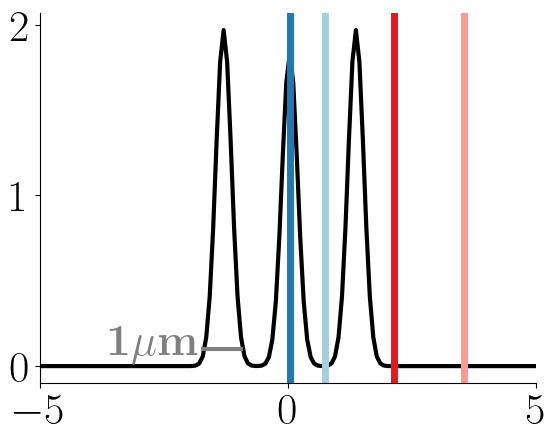

In [110]:
xvec = np.linspace(-14,14,400)
plt.plot(xvec,SM3.C_tot[0,:],lw=3,c='k',label='Init. C')

plt.axvline(xvec[200],lw=5,label='Stimulated spine')
plt.axvline(xvec[210],lw=5,c=C[ColorDict['Control']-1],label='Inside cluster')
plt.axvline(xvec[230],lw=5,c=C[ColorDict['CHX']],label='Outside cluster')
plt.axvline(xvec[250],lw=5,c=C[ColorDict['CHX']-1],label='Away from cluster')
plt.xlim([-5,5])
plt.plot([xvec[175],xvec[186]],[0.1,0.1],c='gray',lw=3)
plt.text(xvec[148],0.06,r'\bf{1}$\mathbf{\mu m}$',color='gray',fontsize=32)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## b

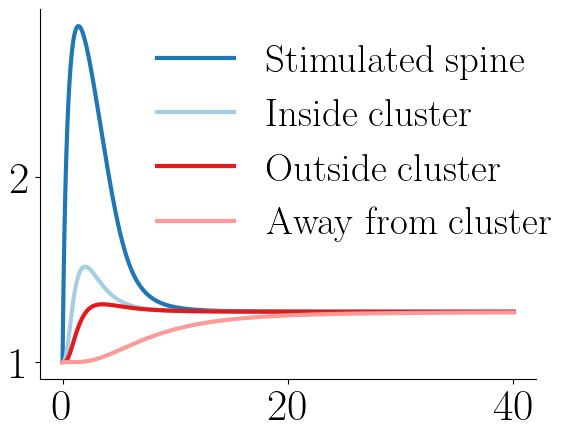

In [111]:
plt.plot(SM3.tvec,SM3.S_tot[:,200],c=C[ColorDict['Control']],lw=3,label='Stimulated spine')
plt.plot(SM3.tvec,SM3.S_tot[:,190],c=C[ColorDict['Control']-1],lw=3,label='Inside cluster')
plt.plot(SM3.tvec,SM3.S_tot[:,170],c=C[ColorDict['CHX']],lw=3,label='Outside cluster')
plt.plot(SM3.tvec,SM3.S_tot[:,150],c=C[ColorDict['CHX']-1],lw=3,label='Away from cluster')
ax = plt.gca()
leg = ax.legend(framealpha=0.5,fontsize=28,loc=1,bbox_to_anchor=(1.1,1.0))
leg.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_yticks([1,2],[1,2])

## c

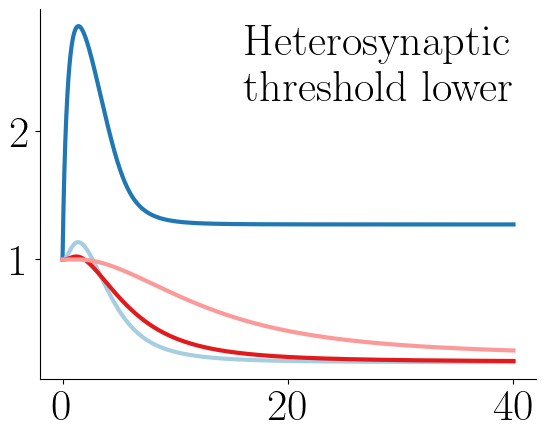

In [112]:
plt.plot(SM3.tvec,SM3.S_tot[:,200],c=C[ColorDict['Control']],lw=3)
plt.plot(SM3.tvec,SM32.S_tot[:,190],c=C[ColorDict['Control']-1],lw=3)
plt.plot(SM3.tvec,SM32.S_tot[:,170],c=C[ColorDict['CHX']],lw=3)
plt.plot(SM3.tvec,SM32.S_tot[:,150],c=C[ColorDict['CHX']-1],lw=3)
plt.text(28,2.5,'Heterosynaptic \n threshold lower',ha='center', va='center',fontsize=32)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## d

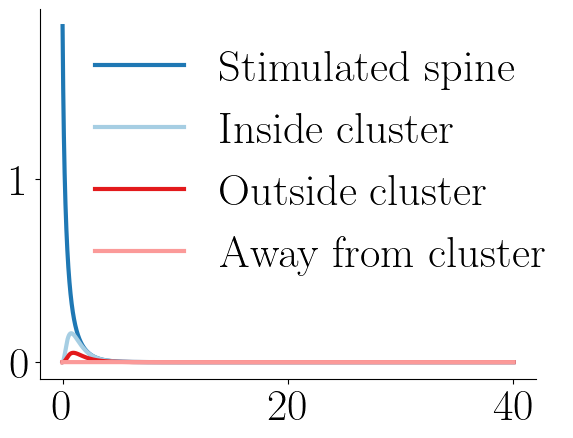

In [113]:
plt.plot(SM3.tvec,SM3.C_tot[:,200],c=C[ColorDict['Control']],lw=3,label='Stimulated spine')
plt.plot(SM3.tvec,SM3.C_tot[:,190],c=C[ColorDict['Control']-1],lw=3,label='Inside cluster')
plt.plot(SM3.tvec,SM3.C_tot[:,170],c=C[ColorDict['CHX']],lw=3,label='Outside cluster')
plt.plot(SM3.tvec,SM3.C_tot[:,150],c=C[ColorDict['CHX']-1],lw=3,label='Away from cluster')
ax = plt.gca()
leg = ax.legend(framealpha=0.5,fontsize=32,loc=1,bbox_to_anchor=(1.1,1.0))
leg.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## e

Text(28, -0.02, 'Unchanged \n parameters')

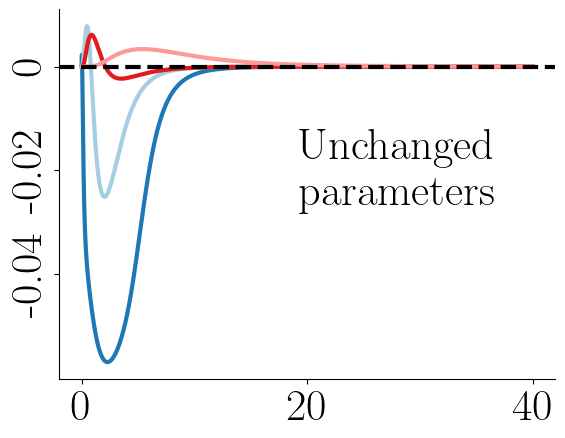

In [114]:
plt.plot(SM3.tvec,SM3.P_tot[:,200]*SM3.F(SM3.S_tot[:,200]),c=C[ColorDict['Control']],lw=3)
plt.plot(SM3.tvec,SM3.P_tot[:,190]*SM3.F(SM3.S_tot[:,190]),c=C[ColorDict['Control']-1],lw=3)
plt.plot(SM3.tvec,SM3.P_tot[:,170]*SM3.F(SM3.S_tot[:,170]),c=C[ColorDict['CHX']],lw=3)
plt.plot(SM3.tvec,SM3.P_tot[:,150]*SM3.F(SM3.S_tot[:,150]),c=C[ColorDict['CHX']-1],lw=3)
plt.axhline(0,lw=3,c='k',ls='--')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_yticks([0,-0.02,-0.04],[0,-0.02,-0.04],rotation=90,va='center')
plt.text(28,-0.02,'Unchanged \n parameters',ha='center', va='center',fontsize=32)

## f

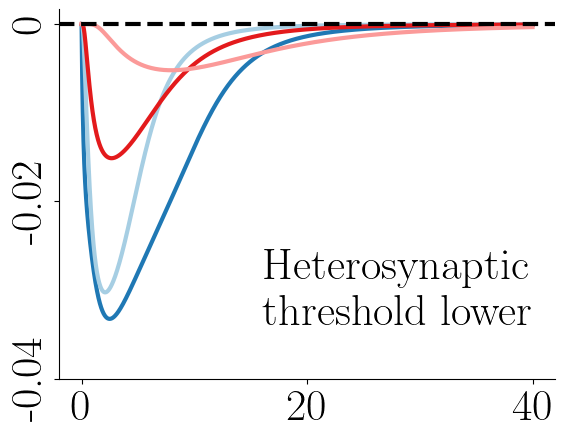

In [115]:
plt.plot(SM3.tvec,SM32.P_tot[:,200]*SM32.F(SM32.S_tot[:,200]),c=C[ColorDict['Control']],lw=3)
plt.plot(SM3.tvec,SM32.P_tot[:,190]*SM32.F(SM32.S_tot[:,190]),c=C[ColorDict['Control']-1],lw=3)
plt.plot(SM3.tvec,SM32.P_tot[:,170]*SM32.F(SM32.S_tot[:,170]),c=C[ColorDict['CHX']],lw=3)
plt.plot(SM3.tvec,SM32.P_tot[:,150]*SM32.F(SM32.S_tot[:,150]),c=C[ColorDict['CHX']-1],lw=3)
plt.text(28,-0.03,'Heterosynaptic \n threshold lower',ha='center', va='center',fontsize=32)
plt.axhline(0,lw=3,c='k',ls='--')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_yticks([0,-0.02,-0.04],[0,-0.02,-0.04],rotation=90,va='center')